# Import necessary packages 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, Record
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, Polygon
from regionmask import Regions
import os
import geopandas as gpd
import regionmask
import calendar
from xclim import sdba
import cftime
import geopandas as gpd
from pyproj import Transformer
from shapely.ops import transform

ref_period = slice('1999-01-01', '2024-12-31')

region_str = 'northeastern_US'

model_list = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR',
       'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL',
       'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G',
       'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM',
       'TaiESM1', 'UKESM1-0-LL']

variant_list = {'ACCESS-CM2': ['r1i1p1f1'],'ACCESS-ESM1-5': ['r1i1p1f1'],'AWI-CM-1-1-MR': ['r1i1p1f1'],'BCC-CSM2-MR': ['r1i1p1f1'],
                'CAMS-CSM1-0': ['r2i1p1f1'],'CESM2': ['r4i1p1f1'],'CESM2-WACCM': ['r1i1p1f1'],'CMCC-CM2-SR5': ['r1i1p1f1'],'CMCC-ESM2': ['r1i1p1f1'],
                'CNRM-CM6-1': ['r1i1p1f2'],'CNRM-CM6-1-HR': ['r1i1p1f2'],'CNRM-ESM2-1': ['r1i1p1f2'],'CanESM5': ['r1i1p1f1'],
                'EC-Earth3': ['r1i1p1f1'],'EC-Earth3-CC': ['r1i1p1f1'],'EC-Earth3-Veg': ['r1i1p1f1'],'EC-Earth3-Veg-LR': ['r1i1p1f1'],
                'FGOALS-g3': ['r1i1p1f1'],'GFDL-CM4': ['r1i1p1f1'],'GFDL-ESM4': ['r1i1p1f1'],'HadGEM3-GC31-LL': ['r1i1p1f3'],
                'IITM-ESM': ['r1i1p1f1'],'INM-CM4-8': ['r1i1p1f1'],'INM-CM5-0': ['r1i1p1f1'],'IPSL-CM6A-LR': ['r1i1p1f1'],
                'KACE-1-0-G': ['r1i1p1f1'],'KIOST-ESM': ['r1i1p1f1'],'MIROC-ES2L': ['r1i1p1f2'],'MIROC6': ['r1i1p1f1'],
                'MPI-ESM1-2-HR': ['r1i1p1f1'],'MPI-ESM1-2-LR': ['r1i1p1f1'],'MRI-ESM2-0': ['r1i1p1f1'],
                'NESM3': ['r1i1p1f1'],'NorESM2-LM': ['r1i1p1f1'],'NorESM2-MM': ['r1i1p1f1'],
                'TaiESM1': ['r1i1p1f1'],'UKESM1-0-LL': ['r1i1p1f2']}

print(region_str)

def overwrite_nc(f1, ds):
    if os.path.exists(f1):
        os.remove(f1)
    ds.to_netcdf(f1)
    print('saved '+f1)

Matplotlib is building the font cache; this may take a moment.


northeastern_US


# Perform BCSD to bias correct and downscale climate model data

### Load climate model data

In [3]:
NEUS_tas = {}
NEUS_tas_vals = {}
for kk, model in enumerate(model_list):
    print(kk, model)
    NEUS_tas_vals[model] = {}
    NEUS_tas[model] = {}
    for ll, var in enumerate(variant_list[model]):
        time_bnds = slice('1850-01-01', '2026-01-01')
        hist_tas_files = sorted(glob.glob('../input_data/CMIP6/historical/daily/tas/tas_day_'+model+'_historical_'+var+'*_NEUS_r128x64.nc'))
        ssp_tas_files = sorted(glob.glob('../input_data/CMIP6/ssp245/daily/tas/tas_day_'+model+'_ssp245_'+var+'*_NEUS_r128x64.nc'))
        
        hist_tas_ds = xr.open_mfdataset(hist_tas_files).tas.sel(time=time_bnds)
        if not np.isin(model, ["IITM-ESM"]):
            pre_2015 = hist_tas_ds.time.dt.year < 2015
            hist_tas_ds = hist_tas_ds.sel(time=pre_2015)
        
        ssp_tas_ds = xr.open_mfdataset(ssp_tas_files).tas.sel(time=time_bnds)
        pre_2026 = ssp_tas_ds.time.dt.year < 2026
        ssp_tas_ds = ssp_tas_ds.sel(time=pre_2026)

        tas_ds = xr.concat([hist_tas_ds, ssp_tas_ds], dim='time') - 273.15
        
        if not os.path.exists('../processed_data/NEUS_tas_vals_'+model+'_'+var+'.npy'):
            NEUS_tas[model][var] = tas_ds
            NEUS_tas[model][var] = NEUS_tas[model][var].sel(time=time_bnds)
            NEUS_tas_vals[model][var] = NEUS_tas[model][var].values            
            np.save('../processed_data/NEUS_tas_vals_'+model+'_'+var+'.npy', NEUS_tas_vals[model][var])

        print('loading...',model,var)
        NEUS_tas_vals[model][var] = np.load('../processed_data/NEUS_tas_vals_'+model+'_'+var+'.npy')
        NEUS_tas[model][var] = xr.DataArray(NEUS_tas_vals[model][var], coords={'time':tas_ds.time,'lat':tas_ds.lat,'lon':tas_ds.lon},
                                            dims=['time','lat','lon'])

0 ACCESS-CM2
loading... ACCESS-CM2 r1i1p1f1
1 ACCESS-ESM1-5
loading... ACCESS-ESM1-5 r1i1p1f1
2 AWI-CM-1-1-MR
loading... AWI-CM-1-1-MR r1i1p1f1
3 BCC-CSM2-MR
loading... BCC-CSM2-MR r1i1p1f1
4 CAMS-CSM1-0
loading... CAMS-CSM1-0 r2i1p1f1
5 CESM2
loading... CESM2 r4i1p1f1
6 CESM2-WACCM
loading... CESM2-WACCM r1i1p1f1
7 CMCC-CM2-SR5
loading... CMCC-CM2-SR5 r1i1p1f1
8 CMCC-ESM2
loading... CMCC-ESM2 r1i1p1f1
9 CNRM-CM6-1
loading... CNRM-CM6-1 r1i1p1f2
10 CNRM-CM6-1-HR
loading... CNRM-CM6-1-HR r1i1p1f2
11 CNRM-ESM2-1
loading... CNRM-ESM2-1 r1i1p1f2
12 CanESM5
loading... CanESM5 r1i1p1f1
13 EC-Earth3
loading... EC-Earth3 r1i1p1f1
14 EC-Earth3-CC
loading... EC-Earth3-CC r1i1p1f1
15 EC-Earth3-Veg
loading... EC-Earth3-Veg r1i1p1f1
16 EC-Earth3-Veg-LR
loading... EC-Earth3-Veg-LR r1i1p1f1
17 FGOALS-g3
loading... FGOALS-g3 r1i1p1f1
18 GFDL-CM4
loading... GFDL-CM4 r1i1p1f1
19 GFDL-ESM4
loading... GFDL-ESM4 r1i1p1f1
20 HadGEM3-GC31-LL
loading... HadGEM3-GC31-LL r1i1p1f3
21 IITM-ESM
loading... IITM-ESM

### Load gridMET data

In [6]:
## save 4km gridMET data as numpy files ##
for yr in range(1999,2025):
    if not os.path.exists('../input_data/gridMET/4km/tmean/npy/tas_4km_'+str(yr)+'.npy'):
        gridMET_4km_npy = xr.open_mfdataset("../input_data/gridMET/4km/tmean/*"+str(yr)+"*4km.nc").air_temperature.rename({'day':'time'}).values
        np.save('../input_data/gridMET/4km/tmean/npy/tas_4km_'+str(yr)+'.npy', gridMET_4km_npy)
        print('saved... ', '../input_data/gridMET/4km/tmean/npy/tas_4km_'+str(yr)+'.npy')
        
## load gridMET data on 4km grid ##
gridMET_4km = xr.open_mfdataset("../input_data/gridMET/4km/tmean/*4km.nc").air_temperature.rename({'day':'time'}).sel(time=ref_period)
gridMET_4km_npy = []
for yr in range(1999,2025):
    print(yr)
    gridMET_4km_npy.append(np.load('../input_data/gridMET/4km/tmean/npy/tas_4km_'+str(yr)+'.npy'))
    
gridMET_4km_npy = np.concatenate(gridMET_4km_npy, axis=0)
gridMET_4km = xr.DataArray(gridMET_4km_npy, coords={'time':gridMET_4km.time,'lat':gridMET_4km.lat,'lon':gridMET_4km.lon}, dims=['time','lat','lon']) - 273.15

## load gridMET data matching GCM grid ##
gridMET_r128x64 = xr.open_mfdataset("../input_data/gridMET/r128x64/tmean/*r128x64.nc").air_temperature.rename({'day':'time'}).load().sel(time=ref_period) - 273.15

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
done #1
done #2


### Bias correct climate model data

In [9]:
BC_GCM_tas_data = {}
GCM_trends_adjustment = {}
for kk, model in enumerate(model_list):
    GCM_trends_adjustment[model] = {}
    BC_GCM_tas_data[model] = {}
    print(kk, model)
    for ll, var in enumerate(variant_list[model]):
        if not os.path.exists('../processed_data/BC_GCM_tas_data_'+model+'_'+var+'.nc'):
            print(model,' correcting GCM data...')
            print(ref_period)
            print(model, NEUS_tas[model][var].time.dt.calendar)
            GCM_data = NEUS_tas[model][var].convert_calendar('proleptic_gregorian', dim='time', align_on='year', missing=np.nan)            
            GCM_data = GCM_data.interpolate_na(dim='time')
            GCM_data_train = GCM_data.sel(time=ref_period)
            
            ## set attributes ##
            GCM_data_train.attrs.update({"standard_name":"temperature",
                                        "units":"K"})
            GCM_data.attrs.update({"standard_name":"temperature",
                                        "units":"K"})
            gridMET_r128x64.attrs.update({"standard_name":"temperature",
                                        "units":"K"})

            ## convert calendar for gridMET data if necessary ##
            gridMET_r128x64 = gridMET_r128x64.sel(time=ref_period) #.convert_calendar(calendar=NEUS_tas[model][var].time.dt.calendar, dim='time', align_on='year')
            GCM_data_train['time'] = gridMET_r128x64.time
            
            ## perform empirical quantile mapping ##
            group = sdba.Grouper("time.dayofyear", window=15)
            QM_doy = sdba.DetrendedQuantileMapping.train(gridMET_r128x64, GCM_data_train, group=group, nquantiles=50, kind="+")
            BC_GCM_tas_data[model][var] = QM_doy.adjust(GCM_data, extrapolation="constant", interp="linear")
            BC_GCM_tas_data[model][var] = BC_GCM_tas_data[model][var].transpose('time', 'lat', 'lon')
            overwrite_nc('../processed_data/BC_GCM_tas_data_'+model+'_'+var+'.nc', BC_GCM_tas_data[model][var])

        print(model,' loading bias-corrected GCM data...')
        GCM_trends_adjustment[model][var] = xr.open_dataset('../processed_data/GCM_trends_adjustment_'+model+'_'+var+'.nc').__xarray_dataarray_variable__
        BC_GCM_tas_data[model][var] = xr.open_dataset('../processed_data/BC_GCM_tas_data_'+model+'_'+var+'.nc').__xarray_dataarray_variable__
        
print('done')

slice('1999-01-01', '2024-12-31', None)
0 ACCESS-CM2
ACCESS-CM2  correcting GCM data...
slice('1999-01-01', '2024-12-31', None)
ACCESS-CM2 proleptic_gregorian
should be 0 => 0
should be >= 0 => 0
should be 0 => 0
saved ../processed_data/BC_GCM_tas_data_ACCESS-CM2_r1i1p1f1.nc
1 ACCESS-ESM1-5
ACCESS-ESM1-5  correcting GCM data...
slice('1999-01-01', '2024-12-31', None)
ACCESS-ESM1-5 proleptic_gregorian
should be 0 => 0
should be >= 0 => 0
should be 0 => 0
saved ../processed_data/BC_GCM_tas_data_ACCESS-ESM1-5_r1i1p1f1.nc
2 AWI-CM-1-1-MR
AWI-CM-1-1-MR  correcting GCM data...
slice('1999-01-01', '2024-12-31', None)
AWI-CM-1-1-MR proleptic_gregorian
should be 0 => 0
should be >= 0 => 0
should be 0 => 0
saved ../processed_data/BC_GCM_tas_data_AWI-CM-1-1-MR_r1i1p1f1.nc
3 BCC-CSM2-MR
BCC-CSM2-MR  correcting GCM data...
slice('1999-01-01', '2024-12-31', None)
BCC-CSM2-MR noleap
should be 0 => 0
should be >= 0 => 860
should be 0 => 0
saved ../processed_data/BC_GCM_tas_data_BCC-CSM2-MR_r1i1p1f1.nc

### Spatially disaggregate bias-corrected climate model data

slice('1999-01-01', '2024-12-31', None)
saved ../processed_data/gridMET_4km_tas_climatology.nc


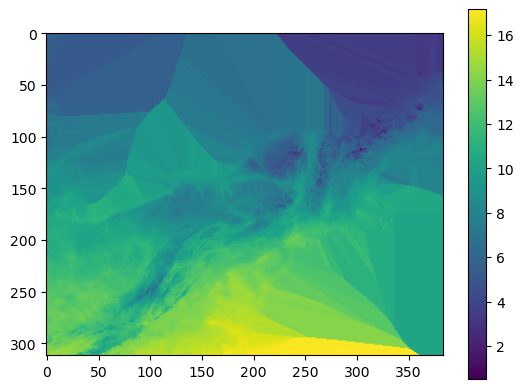

In [13]:
#####################################################
# Step 1 : Calculate ERA5 climatology on 25km grid ##
#####################################################
print(ref_period)
gridMET_4km_climatology = gridMET_4km.sel(time=ref_period).mean('time')
ff_gridMET_clim = '../processed_data/gridMET_4km_tas_climatology.nc'
overwrite_nc(ff_gridMET_clim, gridMET_4km_climatology)
gridMET_4km_climatology

In [ ]:
###############################################################
# Step 2 : use CDO to regrid 4km climatology to r128x64 grid ##
###############################################################

##### Run the following line from the command line #####
cdo remapbil,r128x64 '../processed_data/gridMET_4km_tas_climatology.nc' '../processed_data/gridMET_r128x64_tas_climatology.nc'
#########################################################

In [14]:
##############################################
# Step 3 : load r128x64 gridMET climatology ##
##############################################
gridMET_r128x64_tas_climatology = xr.open_dataset('../processed_data/gridMET_r128x64_tas_climatology.nc').__xarray_dataarray_variable__.load()
gridMET_r128x64_tas_climatology

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 64, lon: 128)> Size: 33kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B -88.59 -85.78 -82.97 ... 82.97 85.78 88.59

In [15]:
#################################################################################
# Step 4 : subtract r128x64 gridMET climatology out of bias-corrected GCM data ##
#################################################################################

BC_GCM_tas_residuals = {}
for kk, model in enumerate(model_list):
    BC_GCM_tas_residuals[model] = {}
    print(model,' correcting GCM data...')
    for ll, var in enumerate(variant_list[model]):
        ff_BC_GCM_tas_residuals = '../processed_data/BC_GCM_tas_residuals_'+model+'_'+var+'.nc'
        print('calculating residuals')
        BC_GCM_tas_residuals[model][var] = BC_GCM_tas_data[model][var] - gridMET_r128x64_tas_climatology 
        overwrite_nc(ff_BC_GCM_tas_residuals, BC_GCM_tas_residuals[model][var])

ACCESS-CM2  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_ACCESS-CM2_r1i1p1f1.nc
ACCESS-ESM1-5  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_ACCESS-ESM1-5_r1i1p1f1.nc
AWI-CM-1-1-MR  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_AWI-CM-1-1-MR_r1i1p1f1.nc
BCC-CSM2-MR  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_BCC-CSM2-MR_r1i1p1f1.nc
CAMS-CSM1-0  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_CAMS-CSM1-0_r2i1p1f1.nc
CESM2  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_CESM2_r4i1p1f1.nc
CESM2-WACCM  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_CESM2-WACCM_r1i1p1f1.nc
CMCC-CM2-SR5  correcting GCM data...
calculating residuals
saved ../processed_data/BC_GCM_tas_residuals_CMCC-CM2-SR5_

In [16]:
##########################################################################################
# Step 5 : Spatially disaggregate bias-corrected climate model data to 4km gridMET grid ##
##########################################################################################

## complete this step in the command line ##
## run in shell "bash 1a_SD.sh" ##

In [17]:
############################
# Step 6 : load BCSD data ##
############################

BCSD_tas = {}
for kk, model in enumerate(model_list):
    BCSD_tas[model] = {}
    print(model,' loading BCSD GCM data...')
    for ll, var in enumerate(variant_list[model]):
        f = '../processed_data/BCSD_tas_'+model+'_'+var+'_4km.nc' 
        BCSD_tas[model][var] = xr.open_dataset(f).__xarray_dataarray_variable__

ACCESS-CM2  loading BCSD GCM data...
ACCESS-ESM1-5  loading BCSD GCM data...
AWI-CM-1-1-MR  loading BCSD GCM data...
BCC-CSM2-MR  loading BCSD GCM data...
CAMS-CSM1-0  loading BCSD GCM data...
CESM2  loading BCSD GCM data...
CESM2-WACCM  loading BCSD GCM data...
CMCC-CM2-SR5  loading BCSD GCM data...
CMCC-ESM2  loading BCSD GCM data...
CNRM-CM6-1  loading BCSD GCM data...
CNRM-CM6-1-HR  loading BCSD GCM data...
CNRM-ESM2-1  loading BCSD GCM data...
CanESM5  loading BCSD GCM data...
EC-Earth3  loading BCSD GCM data...
EC-Earth3-CC  loading BCSD GCM data...
EC-Earth3-Veg  loading BCSD GCM data...
EC-Earth3-Veg-LR  loading BCSD GCM data...
FGOALS-g3  loading BCSD GCM data...
GFDL-CM4  loading BCSD GCM data...
GFDL-ESM4  loading BCSD GCM data...
HadGEM3-GC31-LL  loading BCSD GCM data...
IITM-ESM  loading BCSD GCM data...
INM-CM4-8  loading BCSD GCM data...
INM-CM5-0  loading BCSD GCM data...
IPSL-CM6A-LR  loading BCSD GCM data...
KACE-1-0-G  loading BCSD GCM data...
KIOST-ESM  loading BCSD

# Create county-level temperature timeseries from gridMET and BCSD-corrected climate model data

#### load BCSD-corrected climate model data

In [19]:
BCSD_tas = {}
for kk, model in enumerate(model_list):
    BCSD_tas[model] = {}  
    print(kk, model)
    print(model,' loading BCSD GCM data...')
    for ll, var in enumerate(variant_list[model]):
        f = '../processed_data/BCSD_tas_'+model+'_'+var+'_4km.nc' 
        BCSD_tas[model][var] = xr.open_dataset(f).__xarray_dataarray_variable__

ACCESS-CM2  loading BCSD GCM data...
ACCESS-ESM1-5  loading BCSD GCM data...
AWI-CM-1-1-MR  loading BCSD GCM data...
BCC-CSM2-MR  loading BCSD GCM data...
CAMS-CSM1-0  loading BCSD GCM data...
CESM2  loading BCSD GCM data...
CESM2-WACCM  loading BCSD GCM data...
CMCC-CM2-SR5  loading BCSD GCM data...
CMCC-ESM2  loading BCSD GCM data...
CNRM-CM6-1  loading BCSD GCM data...
CNRM-CM6-1-HR  loading BCSD GCM data...
CNRM-ESM2-1  loading BCSD GCM data...
CanESM5  loading BCSD GCM data...
EC-Earth3  loading BCSD GCM data...
EC-Earth3-CC  loading BCSD GCM data...
EC-Earth3-Veg  loading BCSD GCM data...
EC-Earth3-Veg-LR  loading BCSD GCM data...
FGOALS-g3  loading BCSD GCM data...
GFDL-CM4  loading BCSD GCM data...
GFDL-ESM4  loading BCSD GCM data...
HadGEM3-GC31-LL  loading BCSD GCM data...
IITM-ESM  loading BCSD GCM data...
INM-CM4-8  loading BCSD GCM data...
INM-CM5-0  loading BCSD GCM data...
IPSL-CM6A-LR  loading BCSD GCM data...
KACE-1-0-G  loading BCSD GCM data...
KIOST-ESM  loading BCSD

#### create mask of each NY state county

/oak/stanford/groups/omramom/group_members/trok/conda/envs/py39_xclim_env/lib/python3.12/site-packages/shapely/creation.py:171: RuntimeWarning: invalid value encountered in linearrings
  return lib.linearrings(coords, out=out, **kwargs)
/oak/stanford/groups/omramom/group_members/trok/conda/envs/py39_xclim_env/lib/python3.12/site-packages/shapely/predicates.py:526: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


0 Albany
1 Allegany
2 Bronx
3 Broome
4 Cattaraugus
5 Cayuga
6 Chautauqua
7 Chemung
8 Chenango
9 Clinton
10 Columbia
11 Cortland
12 Delaware
13 Dutchess
14 Erie
15 Essex
16 Franklin
17 Fulton
18 Genesee
19 Greene
20 Hamilton
21 Herkimer
22 Jefferson
23 Kings
24 Lewis
25 Livingston
26 Madison
27 Monroe
28 Montgomery
29 Nassau
30 New York
31 Niagara
32 Oneida
33 Onondaga
34 Ontario
35 Orange
36 Orleans
37 Oswego
38 Otsego
39 Putnam
40 Queens
41 Rensselaer
42 Richmond
43 Rockland
44 Saratoga
45 Schenectady
46 Schoharie
47 Schuyler
48 Seneca
49 St Lawrence
50 Steuben
51 Suffolk
52 Sullivan
53 Tioga
54 Tompkins
55 Ulster
56 Warren
57 Washington
58 Wayne
59 Westchester
60 Wyoming
61 Yates
saved ../processed_data/county_masks.nc


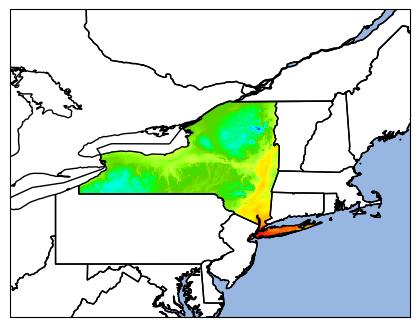

In [3]:
ff = '../processed_data/county_masks.nc'
if not os.path.exists(ff):
    us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
    ny_index = 34
    NY_poly = Polygon(us_states[ny_index].coords)
    
    #######################
    ## create state mask ##
    #######################
    ds_4km = xr.open_dataset('../processed_data/BCSD_tas_ACCESS-CM2_r1i1p1f1_4km.nc').__xarray_dataarray_variable__.isel(time=10000)
    state_mask = 99*np.ones([len(ds_4km.lon), len(ds_4km.lat)])
    for i, lon in enumerate(ds_4km.lon):
        for j, lat in enumerate(ds_4km.lat):
            state_mask[i,j] = NY_poly.contains(Point(lon, lat))
            if (lon < -79) & (lat > 43):
                state_mask[i,j] = 0
    
    state_mask[state_mask==0] = np.nan
    state_mask = xr.DataArray(state_mask, coords={'lon':ds_4km.lon, 'lat':ds_4km.lat}, dims=['lon','lat'])
    
    #########################
    ## create county masks ##
    #########################
    NY_counties = gpd.read_file('../input_data/Shapefiles/Counties.shp')
    project = Transformer.from_crs(NY_counties.geometry.crs, "EPSG:4326", always_xy=True).transform
    NY_counties = NY_counties.set_index(NY_counties.NAME.values)
    
    ## transform to lat lon coordinate system ##
    for cty in NY_counties.NAME.values:
        NY_counties.loc[cty, 'geometry'] = transform(project, NY_counties.loc[cty, 'geometry'])
    
    ## create 4km lat/lon mask of NY counties ##
    ds_4km = xr.open_dataset('../processed_data/BCSD_tas_ACCESS-CM2_r1i1p1f1_4km.nc').__xarray_dataarray_variable__.isel(time=10000)
    county_masks = 99*np.ones([len(NY_counties.NAME), len(ds_4km.lat), len(ds_4km.lon)])
    for cty_num, county in enumerate(NY_counties.NAME.values):
        print(cty_num, county)
        for i, lon in enumerate(ds_4km.lon):
            for j, lat in enumerate(ds_4km.lat):
                county_masks[cty_num,j,i] = NY_counties.iloc[cty_num].geometry.contains(Point(lon, lat))
                
    county_masks[county_masks==0] = np.nan
    county_masks = xr.DataArray(county_masks, coords={'county':NY_counties.NAME.values, 'lat':ds_4km.lat, 'lon':ds_4km.lon}, dims=['county', 'lat','lon'])
    county_masks = county_masks * state_mask
    overwrite_nc(ff, county_masks.to_dataset(name='masks'))

county_masks = xr.open_dataset('../processed_data/county_masks.nc').masks
county_masks

#### create county-level timeseries from gridMET data

In [20]:
#######################
## load gridMET data ##
#######################
gridMET_4km = xr.open_mfdataset("../input_data/gridMET/4km/tmean/*4km.nc").air_temperature.rename({'day':'time'})
gridMET_4km_npy = []
for yr in range(1999,2025):
    print(yr)
    gridMET_4km_npy.append(np.load('../input_data/gridMET/4km/tmean/npy/tas_4km_'+str(yr)+'.npy'))
    
gridMET_4km_npy = np.concatenate(gridMET_4km_npy, axis=0)
gridMET_4km = xr.DataArray(gridMET_4km_npy, coords={'time':gridMET_4km.time,'lat':gridMET_4km.lat,'lon':gridMET_4km.lon}, dims=['time','lat','lon']) - 273.15
print('done')

#########################################################
## create gridMET TMEAN time series for each NY county ##
#########################################################
ff = '../processed_data/NY_county_gridMET_timeseries.nc'
if os.path.exists(ff):
    print('loading...', ff)
    NY_county_gridMET_timeseries = xr.open_dataset(ff).TMEAN       
else:
    NY_county_gridMET_timeseries = []
    for cty in county_masks.county.values:
        print(cty)
        weights = np.cos(np.deg2rad(gridMET_4km.lat))
        NY_county_gridMET_timeseries.append((gridMET_4km*county_masks.sel(county=cty)).weighted(weights).mean(['lat','lon']).expand_dims({'county':[cty]}))
    
    NY_county_gridMET_timeseries = xr.concat(NY_county_gridMET_timeseries, dim='county')
    print('saving...', ff)
    overwrite_nc(ff, NY_county_gridMET_timeseries.to_dataset(name='TMEAN'))        

NY_county_gridMET_timeseries = xr.open_dataset(ff).TMEAN

1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
done


#### create county-level timeseries from BCSD-corrected climate model data

In [3]:
# * note: depending on computational resources, this cell can take a long time to run. consider parallelization if possible. * #

## create area-weighted TMEAN time series for each NY county ##
county_masks = xr.open_dataset('../processed_data/county_masks.nc').masks
NY_county_timeseries = {}
for kk, model in enumerate(model_list):
    NY_county_timeseries[model] = {}
    for ll, var in enumerate(variant_list[model]):
        ff = '../processed_data/NY_county_mean_'+model+'_'+var+'.nc'
        if os.path.exists(ff):
            print('loading...', ff)
            NY_county_timeseries[model][var] = xr.open_dataset(ff)        
        else:
            NY_county_timeseries[model][var] = []
            for jj, cty in enumerate(county_masks.county.values):
                print(model, var, jj, cty)
                weights = np.cos(np.deg2rad(BCSD_tas[model][var].lat))
                NY_county_timeseries[model][var].append((BCSD_tas[model][var]*county_masks.sel(county=cty)).weighted(weights).mean(['lat','lon']).expand_dims({'county':[cty]}))
            
            NY_county_timeseries[model][var] = xr.concat(NY_county_timeseries[model][var], dim='county')
            print('saving...', ff)
            overwrite_nc(ff, NY_county_timeseries[model][var].to_dataset(name='TMEAN'))        
    
print('done')

ACCESS-CM2 r1i1p1f1
loading... ../processed_data/NY_county_mean_ACCESS-CM2_r1i1p1f1.nc
ACCESS-ESM1-5 r1i1p1f1
loading... ../processed_data/NY_county_mean_ACCESS-ESM1-5_r1i1p1f1.nc
AWI-CM-1-1-MR r1i1p1f1
loading... ../processed_data/NY_county_mean_AWI-CM-1-1-MR_r1i1p1f1.nc
BCC-CSM2-MR r1i1p1f1
loading... ../processed_data/NY_county_mean_BCC-CSM2-MR_r1i1p1f1.nc
CAMS-CSM1-0 r2i1p1f1
loading... ../processed_data/NY_county_mean_CAMS-CSM1-0_r2i1p1f1.nc
CESM2 r4i1p1f1
loading... ../processed_data/NY_county_mean_CESM2_r4i1p1f1.nc
CESM2-WACCM r1i1p1f1
loading... ../processed_data/NY_county_mean_CESM2-WACCM_r1i1p1f1.nc
CMCC-CM2-SR5 r1i1p1f1
loading... ../processed_data/NY_county_mean_CMCC-CM2-SR5_r1i1p1f1.nc
CMCC-ESM2 r1i1p1f1
loading... ../processed_data/NY_county_mean_CMCC-ESM2_r1i1p1f1.nc
CNRM-CM6-1 r1i1p1f2
loading... ../processed_data/NY_county_mean_CNRM-CM6-1_r1i1p1f2.nc
CNRM-CM6-1-HR r1i1p1f2
loading... ../processed_data/NY_county_mean_CNRM-CM6-1-HR_r1i1p1f2.nc
CNRM-ESM2-1 r1i1p1f2
loadin

<xarray.Dataset> Size: 32MB
Dimensions:  (county: 62, time: 63360)
Coordinates:
  * county   (county) <U11 3kB 'Albany' 'Allegany' 'Bronx' ... 'Wyoming' 'Yates'
  * time     (time) object 507kB 1850-01-01 12:00:00 ... 2025-12-30 12:00:00
Data variables:
    TMEAN    (county, time) float64 31MB ...